In [4]:
import glob
import os
#import cv2
import glob
import re
import json
import h5py
import importlib

#import _pickle as pkl
import matplotlib as mpl
#import tifffile as tf
import pandas as pd
import pylab as pl
import seaborn as sns
import numpy as np

In [5]:
import analyze2p.utils as hutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.plotting as pplot

import analyze2p.receptive_fields.utils as rf_utils
import analyze2p.gratings.utils as gutils
import analyze2p.gratings.bootstrap_osi as osi
import analyze2p.extraction.rois as roiutils
import analyze2p.aggregate_datasets as aggr


ImportError: No module named analyze2p.utils

In [3]:

def get_experiment_list(datakey, traceid='traces001', trace_type='corrected',\
                        rootdir='/n/coxfs01/2p-data'):
    session, animalid, fovn = hutils.split_datakey_str(datakey)
    
    fov_dir = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_*' % fovn))[0]
    run_list = sorted(glob.glob(os.path.join(fov_dir, '*_run[0-9]')), 
                        key=hutils.natural_keys)
    experiment_list = list(set([os.path.split(f)[-1].split('_run')[0] \
                                for f in run_list]))
    if 'gratings' in experiment_list and (20190405 <= int(session) < 20190511):
        # Old experiment, where "gratings" were actually RFs
        experiment_list = [e for e in experiment_list if e != 'gratings']
        experiment_list.append('rfs') # These are always 5 degree res        
        
    return experiment_list
 
def aggregate_session_info(traceid='traces001', trace_type='corrected', 
                           state='awake', fov_type='zoom2p0x', 
                           visual_areas=['V1', 'Lm', 'Li'],
                           blacklist=['20190426', '20190514', '20190530'], 
                           rootdir='/n/coxfs01/2p-data'):
                           #aggregate_dir='/n/coxfs01/julianarhee/aggregate-visual-areas'):
    all_rats = [os.path.split(os.path.split(f)[0])[-1] \
                for f in glob.glob(os.path.join(rootdir, 'JC*', 'sessionmeta.json'))]
    s_list = []
    dcounter = 0
    for animalid in all_rats: 
        # Get metadata for this rat's sessions:
        with open(os.path.join(rootdir, animalid, 'sessionmeta.json'), 'r') as f:
            sessionmeta = json.load(f)
        # Get session data paths, if exist:
        for va in visual_areas:
            curr_session_list = [str(k) for k, v in sessionmeta.items()\
                                 if v['state']==state \
                                 and v['visual_area'].lower()==va.lower()]
            if len(curr_session_list) > 0:
                for s in curr_session_list:
                    session_str = s.split('_')[0]
                    fov_str = s.split('_')[-1]
                    dk = '%s_%s_fov%i' % (session_str, animalid, int(fov_str[3:]))
                    if session_str in blacklist:
                        continue
                    found_fovs = glob.glob(os.path.join(rootdir, animalid, session_str,
                                                        '%s*' % fov_str))
                    for fov_dir in found_fovs:
                        experiment_list = get_experiment_list(dk, traceid=traceid)
                        for e in experiment_list:
                            if 'dyn' in e or e=='blobs_pos' or e in ['XgratingsX', 'xblobsx']:
                                continue
                            meta_df = pd.DataFrame({
                                'visual_area': va, 
                                'animalid': animalid, 
                                'experiment': e,
                                'session': session_str,
                                'fov': '%s_%s' % (fov_str, fov_type),
                                'fovnum': int(fov_str[3:]),
                                'datakey': dk}, \
                                                   index=[dcounter])
                            dcounter += 1
                            s_list.append(meta_df)
            #else:
            #    print("[%s] %s - skipping" % (animalid, va))
    
    sessiondata = pd.concat(s_list, axis=0)
    
    return sessiondata


def get_dataset_info(aggregate_dir='/n/coxfs01/julianarhee/aggregate-visual-areas',
                      traceid='traces001', trace_type='corrected', state='awake',
                      fov_type='zoom2p0x', visual_areas=['V1', 'Lm', 'Li'],
                      blacklist = ['20190514', '20190530'], 
                      rootdir='/n/coxfs01/2p-data', create_new=False):
    
    dataset_info_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
    if os.path.exists(dataset_info_fpath) and create_new is False:
        with open(dataset_info_fpath, 'rb') as f:
            sessiondata = pkl.load(f)
    else:
        sessiondata = aggregate_session_info(traceid=traceid, trace_type=trace_type, 
                                               state=state, fov_type=fov_type, 
                                               visual_areas=visual_areas,
                                               blacklist=blacklist, 
                                               rootdir=rootdir)
                                               #aggregate_dir=optsE.aggregate_dir)
                
        experiment_types = sorted(sessiondata['experiment'].unique(), key=hutils.natural_keys)
        experiment_ids = dict((exp, i) for i, exp in enumerate(experiment_types))
        animal_names = sorted(sessiondata['animalid'].unique(), key=hutils.natural_keys)
        animal_ids = dict((animal, i) for i, animal in enumerate(animal_names))
        
        sessiondata['exp_no'] = [int(experiment_ids[exp]) for exp in sessiondata['experiment']]
        sessiondata['animal_no'] = [int(animal_ids[animal]) for animal in sessiondata['animalid']]

        #%
        with open(dataset_info_fpath, 'wb') as f:
            pkl.dump(sessiondata, f, protocol=2)
    print(dataset_info_fpath)
    return sessiondata


In [4]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)

In [5]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
response_type='dff'
traceid = 'traces001'

# Re-create session meta

In [6]:
sessiondata = get_dataset_info( create_new=False, state='awake')

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info.pkl


In [7]:
'20190306_JC061_fov2' in sessiondata['datakey'].values

True

In [8]:
cells, missing_seg = aggr.get_cells_by_area(sessiondata, create_new=True,
                                    return_missing=True, verbose=True)
cells = cells[cells.visual_area.isin(visual_areas)]


Assigning cells
    20190306_JC061_fov2 (Lm): got 222 cells
    20190306_JC061_fov3 (Lm): got 269 cells
    20190319_JC067_fov1 (Ll): got 62 cells
    20190319_JC067_fov1 (Li): got 31 cells
    20190320_JC067_fov1 (Ll): got 134 cells
    20190320_JC067_fov1 (Li): got 21 cells
list index out of range
Error loading analysis: retino_run2 (20190314_JC070_fov1)
    20190314_JC070_fov1 (Li): got 137 cells
    20190315_JC070_fov1 (Li): got 135 cells
    20190315_JC070_fov2 (Li): got 102 cells
    20190315_JC070_fov3 (Lm): got 220 cells
    20190316_JC070_fov1 (Li): got 152 cells
    20190321_JC070_fov1 (Li): got 63 cells
    20190321_JC070_fov2 (Li): got 34 cells
    20190321_JC070_fov2 (Ll): got 54 cells
    20190322_JC073_fov1 (Lm): got 106 cells
    20190322_JC073_fov1 (Li): got 181 cells
    20190327_JC073_fov1 (Lm): got 42 cells
    20190327_JC073_fov1 (Li): got 111 cells
    20190422_JC076_fov1 (Lm): got 73 cells
    20190422_JC076_fov1 (Li): got 95 cells
    20190422_JC076_fov1 (Por): 

Traceback (most recent call last):
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3080, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 4554, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 4562, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 1

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py", line 1170, in get_cells_by_area
    retinorun = all_retinos.iloc[all_retinos[1].idxmax()][0]
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/si

    20190430_JC078_fov1 (Lm): got 285 cells
    20190504_JC078_fov1 (Lm): got 169 cells
    20190504_JC078_fov1 (V1): got 46 cells
    20190509_JC078_fov1 (Lm): got 168 cells
    20190509_JC078_fov1 (V1): got 44 cells
    20190513_JC078_fov1 (Lm): got 279 cells
    20190506_JC080_fov1 (Lm): got 276 cells
    20190602_JC080_fov2 (Lm): got 72 cells
    20190602_JC080_fov2 (Al): got 68 cells
    20190603_JC080_fov1 (Lm): got 271 cells
    20190507_JC083_fov1 (V1): got 182 cells
    20190508_JC083_fov1 (V1): got 57 cells
    20190508_JC083_fov1 (Lm): got 193 cells
    20190510_JC083_fov1 (V1): got 183 cells
    20190511_JC083_fov1 (V1): got 174 cells
    20190512_JC083_fov1 (V1): got 74 cells
    20190512_JC083_fov1 (Lm): got 283 cells
    20190517_JC083_fov1 (V1): got 41 cells
    20190517_JC083_fov1 (Lm): got 190 cells
    20190522_JC084_fov1 (V1): got 260 cells
    20190525_JC084_fov1 (Lm): got 235 cells
    20190622_JC085_fov1 (V1): got 312 cells
    20190522_JC089_fov1 (Li): got 28 ce

Traceback (most recent call last):
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3080, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 4554, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 4562, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 1

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py", line 1170, in get_cells_by_area
    retinorun = all_retinos.iloc[all_retinos[1].idxmax()][0]
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/si

... no seg. 20191008_JC091_fov1 (retino_run1)
... no seg. 20190527_JC092_fov2 (retino_run1)


Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py", line 1174, in get_cells_by_area
    fov, retinorun=retinorun)
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/extraction/rois.py", line 180, in load_roi_assignments
    "Assignment results not found: %s" % results_fpath
AssertionError: Assignment results not found: /n/coxfs01/2p-data/JC091/20191008/FOV1_zoom2p0x/retino_run1/retino_analysis/segmentation/roi_assignments.json
Traceback (most recent call last):
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3080, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hash

    20190527_JC092_fov3 (Li): got 118 cells
    20190528_JC092_fov1 (Li): got 47 cells
    20190613_JC097_fov1 (V1): got 225 cells
... no seg. 20190615_JC097_fov1 (retino_run1)


Traceback (most recent call last):
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3080, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 4554, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 4562, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 1

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py", line 1170, in get_cells_by_area
    retinorun = all_retinos.iloc[all_retinos[1].idxmax()][0]
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/si

    20190615_JC097_fov2 (V1): got 335 cells
... no seg. 20190615_JC097_fov3 (retino_run1)


Traceback (most recent call last):
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3080, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 4554, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 4562, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 1

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py", line 1170, in get_cells_by_area
    retinorun = all_retinos.iloc[all_retinos[1].idxmax()][0]
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/si

    20190616_JC097_fov1 (V1): got 432 cells
    20190617_JC097_fov1 (V1): got 438 cells
    20190618_JC097_fov1 (Lm): got 172 cells
    20190609_JC099_fov1 (Li): got 167 cells
    20190612_JC099_fov1 (Li): got 164 cells
    20190612_JC099_fov1 (Ll): got 84 cells
    20190617_JC099_fov1 (Li): got 78 cells
... no seg. 20191004_JC110_fov1 (retino_run1)


Traceback (most recent call last):
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3080, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 4554, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 4562, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 1

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py", line 1170, in get_cells_by_area
    retinorun = all_retinos.iloc[all_retinos[1].idxmax()][0]
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/si

    20191004_JC110_fov2 (V1): got 363 cells
... no seg. 20191004_JC110_fov4 (retino_run1)


Traceback (most recent call last):
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3080, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 4554, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 4562, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 1

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py", line 1170, in get_cells_by_area
    retinorun = all_retinos.iloc[all_retinos[1].idxmax()][0]
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/si

    20191006_JC110_fov1 (V1): got 391 cells
    20191012_JC113_fov2 (Li): got 55 cells
... no seg. 20191012_JC113_fov3 (retino_run1)


Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py", line 1174, in get_cells_by_area
    fov, retinorun=retinorun)
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/extraction/rois.py", line 180, in load_roi_assignments
    "Assignment results not found: %s" % results_fpath
AssertionError: Assignment results not found: /n/coxfs01/2p-data/JC113/20191012/FOV3_zoom2p0x/retino_run1/retino_analysis/segmentation/roi_assignments.json


    20191017_JC113_fov1 (Li): got 214 cells
    20191018_JC113_fov1 (Li): got 81 cells
list index out of range
Error loading analysis: retino_run1 (20191108_JC113_fov2)
... no seg. 20191108_JC113_fov2 (retino_run1)


Traceback (most recent call last):
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3080, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 4554, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 4562, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 1

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py", line 1170, in get_cells_by_area
    retinorun = all_retinos.iloc[all_retinos[1].idxmax()][0]
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/si

    20191111_JC117_fov1 (V1): got 226 cells
    20191111_JC117_fov2 (Lm): got 189 cells
    20191106_JC120_fov1 (Li): got 189 cells
... no seg. 20191106_JC120_fov3 (retino_run1)
... no seg. 20191106_JC120_fov4 (retino_run1)


Traceback (most recent call last):
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3080, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 4554, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 4562, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 1

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py", line 1170, in get_cells_by_area
    retinorun = all_retinos.iloc[all_retinos[1].idxmax()][0]
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/si

    20191111_JC120_fov1 (Lm): got 6 cells
    20191111_JC120_fov1 (Li): got 151 cells
Segmentation: missing 12 dsets
('20190502_JC076_fov1', 'retino_run1')
('20191007_JC091_fov1', 'retino_run1')
('20191008_JC091_fov1', 'retino_run1')
('20190527_JC092_fov2', 'retino_run1')
('20190615_JC097_fov1', 'retino_run1')
('20190615_JC097_fov3', 'retino_run1')
('20191004_JC110_fov1', 'retino_run1')
('20191004_JC110_fov4', 'retino_run1')
('20191012_JC113_fov3', 'retino_run1')
('20191108_JC113_fov2', 'retino_run1')
('20191106_JC120_fov3', 'retino_run1')
('20191106_JC120_fov4', 'retino_run1')


In [9]:
missing_seg

[('20190502_JC076_fov1', 'retino_run1'),
 ('20191007_JC091_fov1', 'retino_run1'),
 ('20191008_JC091_fov1', 'retino_run1'),
 ('20190527_JC092_fov2', 'retino_run1'),
 ('20190615_JC097_fov1', 'retino_run1'),
 ('20190615_JC097_fov3', 'retino_run1'),
 ('20191004_JC110_fov1', 'retino_run1'),
 ('20191004_JC110_fov4', 'retino_run1'),
 ('20191012_JC113_fov3', 'retino_run1'),
 ('20191108_JC113_fov2', 'retino_run1'),
 ('20191106_JC120_fov3', 'retino_run1'),
 ('20191106_JC120_fov4', 'retino_run1')]

In [10]:
'20190306_JC061_fov2' in cells['datakey'].values

True

# Load all cells (assigned)

In [11]:
sdata, cells0, missing_ = aggr.get_aggregate_info(visual_areas=visual_areas, 
                                            create_new=True,
                                            return_cells=True, return_missing=True)
all_cell_counts = cells0[['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates().groupby(['visual_area']).count().reset_index()

print(all_cell_counts.groupby(['visual_area']).sum())

Loading old...
Assigning cells
list index out of range
Error loading analysis: retino_run2 (20190314_JC070_fov1)
list index out of range
Error loading analysis: retino_run1 (20191108_JC113_fov2)
Segmentation: missing 12 dsets
             datakey  cell
visual_area               
Li              3305  3305
Lm              3922  3922
V1              4009  4009


In [12]:
missing_

[('20190502_JC076_fov1', 'retino_run1'),
 ('20191007_JC091_fov1', 'retino_run1'),
 ('20191008_JC091_fov1', 'retino_run1'),
 ('20190527_JC092_fov2', 'retino_run1'),
 ('20190615_JC097_fov1', 'retino_run1'),
 ('20190615_JC097_fov3', 'retino_run1'),
 ('20191004_JC110_fov1', 'retino_run1'),
 ('20191004_JC110_fov4', 'retino_run1'),
 ('20191012_JC113_fov3', 'retino_run1'),
 ('20191108_JC113_fov2', 'retino_run1'),
 ('20191106_JC120_fov3', 'retino_run1'),
 ('20191106_JC120_fov4', 'retino_run1')]

In [13]:
sdata[sdata.datakey=='20191111_JC117_fov1']['visual_area'].unique()

array(['V1'], dtype=object)

In [14]:
'20190306_JC061_fov2' in sdata['datakey'].values

True

In [15]:
sdata, cells0, missing_ = aggr.get_aggregate_info(visual_areas=visual_areas, 
                                                  create_new=False,
                                                  return_cells=True, return_missing=True)
all_cell_counts = cells0[['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates().groupby(['visual_area']).count().reset_index()

print(all_cell_counts.groupby(['visual_area']).sum())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
             datakey  cell
visual_area               
Li              3305  3305
Lm              3922  3922
V1              4009  4009


In [16]:
# Save counts
statdir = os.path.join(aggregate_dir, 'data-stats','counts')
if not os.path.exists(statdir):
    os.makedirs(statdir)
counts_outfile = os.path.join(statdir, 'all_assigned_cells.csv')
all_cell_counts.to_csv (r'%s' % counts_outfile, index=False, header=True)
print(counts_outfile)

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/counts/all_assigned_cells.csv


# Aggregate counts

In [17]:
import analyze2p.gratings.bootstrap_osi as osi
import analyze2p.receptive_fields.utils as rfutils

In [18]:

def get_gratings_data(assigned_cells, response_type='dff', traceid='traces001',
                     trial_epoch='stimulus', responsive_test='nstds',
                     responsive_thr=10., n_bootstrap_iters=500, n_resamples=20,
                     verbose=True):
    # def get_gratings_data(assigned_cells, )
    ori_fit_desc = gutils.get_fit_desc(response_type=response_type, 
                                responsive_test=responsive_test, 
                                responsive_thr=responsive_thr,
                                n_bootstrap_iters=n_bootstrap_iters, 
                                n_resamples=n_resamples)
    gdata, no_fits, missing_fits = osi.aggregate_ori_fits(assigned_cells, 
                                    fit_desc=ori_fit_desc, 
                                    traceid=traceid, return_missing=True) 
    if verbose:
        print("Missing %i datasets" % len(missing_fits))
        print("No cells with good fits: %i datasets" % len(no_fits))
    counts = gdata[gdata['gof']>=fit_thr][['visual_area', 'datakey', 'cell']]\
                .drop_duplicates()
    u_dkeys = aggr.drop_repeats(counts)
    NDATA0 = aggr.load_responsive_neuraldata('gratings', traceid=traceid,
                                            response_type=response_type,
                                            trial_epoch=trial_epoch,
                                            responsive_test=responsive_test,
                                            responsive_thr=responsive_thr)
    NDATA = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])

    return NDATA, u_dkeys, gdata

In [19]:
def get_rf_data(assigned_cells, rf_meta, response_type='dff', 
                do_spherical_correction=False, reliable_only=False,
                traceid='traces001', trial_epoch='stimulus', 
                responsive_test='nstds', responsive_thr=7,
               verbose=True):
    # load fits
    rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                    do_spherical_correction=do_spherical_correction)
    rfdata = rfutils.aggregate_rfdata(rf_meta, assigned_cells, fit_desc=rf_fit_desc,
                                    reliable_only=False)
    # Combined rfs5/rfs10 (V1/LM, default is 5-deg; LI, default is 10-deg)
    combined_rfs = rfutils.combine_rfs_single(rfdata) 
    # Each cell should have only 1 value:
    assert combined_rfs.groupby(['visual_area', 'datakey', 'cell'])['experiment']\
        .count().max() == 1
    # Count 
    counts = combined_rfs[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()
    u_dkeys = aggr.drop_repeats(counts)
    # Load all the rf data (both rfs5, rfs10)
    NDATA0 = aggr.load_responsive_neuraldata('rfs', traceid=traceid,
                                               response_type=response_type,
                                               trial_epoch=trial_epoch,
                                               responsive_test=responsive_test,
                                               responsive_thr=responsive_thr)
    # RFs may have 2 experiments (duplicate), so only keep the best one
    ucombined = pd.concat([g for (va, dk), g \
                            in combined_rfs.groupby(['visual_area', 'datakey'])
                            if (va, dk) in u_dkeys])
    NDATA = pd.concat([g for (va, dk, exp), g in \
            NDATA0.groupby(['visual_area', 'datakey', 'experiment']) \
            if not ucombined\
            .query('@va==visual_area and @dk==datakey and @exp==experiment')\
            .empty])
    
    return NDATA, u_dkeys, rfdata, combined_rfs

In [20]:
responsive_test='ROC'
responsive_thr=10 if responsive_test=='nstds' else 0.05
n_stds = 2.5
trial_epoch = 'stimulus'

blobs_test=responsive_test; blobs_thr=responsive_thr;
rfs_test='nstds'; rfs_thr=7.0;
retino_thr=0.01; retino_delay=0.5;

# Grating selection
# -----------------------------------------------------------
gratings_test=responsive_test; gratings_thr=responsive_thr;
fit_thr=0.5; n_bootstrap_iters=500; n_resamples=20;

# Output dir
dst_dir = os.path.join(aggregate_dir, 'data-stats', 'figures')
data_id = '%s_%s_%s_%s-thr-%.2f' % (traceid, trial_epoch, response_type,
                                    responsive_test, responsive_thr)
print(data_id)

traces001_stimulus_dff_ROC-thr-0.05


In [21]:
create_new=True
redo_retino=True # Rerun if re-made sessiondata/cells
final_counts_dfile = os.path.join(dst_dir, 'unique_counts.pkl')
if create_new is False:
    try:
        if not create_new:
            with open(final_counts_dfile, 'rb') as f:
                final_cells = pkl.load(f, encoding='latin1')
        responsive_by_stimulus = final_cells['responsive_by_stimulus']
        aggr_datakeys = final_cells['aggr_datakeys']
        COUNTS = final_cells['counts']
        # final_cells = {'responsive_by_stimulus': responsive_by_stimulus,
        #                'unique_datakeys': aggr_datakeys,
        #                'counts': COUNTS}
    except Exception as e:
        traceback.print_exc()
        create_new=True
print("NEW? %s" % str(create_new))

NEW? True


In [24]:
final_counts_dfile = os.path.join(dst_dir, 'unique_counts.pkl')

In [25]:
if create_new:
    counts_=[]
    cellids_=[]
    allcells_=[]
    ukeys_=[]
    for experiment in ['rfs', 'retino', 'gratings', 'blobs']:
        print("%s -------------------------------------" % experiment)
        if experiment in ['rfs', 'rfs10']:
            assigned_cells, rf_meta = aggr.select_assigned_cells(cells0, sdata, 
                                                  experiments=['rfs', 'rfs10']) 
            NDATA, rfs_dkeys, rfdata, combined_rfs = get_rf_data(assigned_cells, rf_meta,
                                                        response_type=response_type, 
                                                        do_spherical_correction=False,
                                                        reliable_only=False,
                                                        traceid=traceid, 
                                                        trial_epoch=trial_epoch, 
                                                        responsive_test=rfs_test, 
                                                        responsive_thr=rfs_thr)
            n_responsive = aggr.count_n_cells(NDATA, name='n_responsive')
            n_total = aggr.count_n_total(assigned_cells, rfs_dkeys)
            u_dkeys = rfs_dkeys
        elif experiment=='retino':
            #retino_thr=0.01; retino_delay=0.5;
            assigned_cells, ret_meta = aggr.select_assigned_cells(cells0, 
                                                        sdata, experiments=['retino'])
            NDATA = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                                        retino_thr=retino_thr, retino_delay=retino_delay,
                                        redo_retino=redo_retino)
            # Get unique dkeys and count
            n_responsive, retino_dkeys = aggr.count_n_responsive(NDATA, u_dkeys=None)
            n_total = aggr.count_n_total(assigned_cells, retino_dkeys)
            u_dkeys = retino_dkeys
        elif experiment=='blobs' or experiment=='gratings':
            assigned_cells, _ = aggr.select_assigned_cells(cells0, sdata, 
                                                    experiments=[experiment])
            NDATA = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                                                   response_type=response_type,
                                                   trial_epoch=trial_epoch,
                                                   responsive_test=blobs_test,
                                                   responsive_thr=blobs_thr)
            # Get unique dkeys and count
            n_responsive, blobs_dkeys = aggr.count_n_responsive(NDATA, u_dkeys=None)
            n_total = aggr.count_n_total(assigned_cells, blobs_dkeys)
            u_dkeys = blobs_dkeys
        # Check counts
        found_none = [(va, k) for (va,k) in n_total[['visual_area', 'datakey']].values \
             if n_responsive.query('@va==visual_area and @k==datakey').empty]
        cols=['visual_area', 'datakey', 'n_responsive']
        for (va_n, dk_n) in found_none:
            n_responsive.loc[len(n_responsive.index), cols] = [va_n, dk_n, 0]

        # Add total counts
        assert n_total.shape==n_responsive.shape, \
                'Incorrect counts: total=%i, responsive=%i' \
                % (n_total.shape[0], n_responsive.shape[0])
        counts = pd.merge(n_responsive, n_total)
        counts['fraction_responsive'] = counts['n_responsive']/counts['n_total'].astype(float)
        counts['stimulus'] = experiment
        counts_.append(counts)
        # Add cell IDs (responsive)
        cellids = NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates().copy()
        cellids['stimulus'] = experiment
        cellids_.append(cellids)
        incl_cells = pd.concat([assigned_cells.query('@va==visual_area and @dk==datakey')
                        for (va, dk), g in NDATA.groupby(['visual_area', 'datakey'])])
        allcells_.append(incl_cells[['visual_area', 'datakey', 'cell']])
        # Save which datasets included (unique)
        unique_keys = pd.DataFrame(u_dkeys).rename(\
                                            columns={0:'visual_area', 1: 'datakey'})
        unique_keys['stimulus'] = experiment
        ukeys_.append(unique_keys)

    # All unique datakeys
    aggr_datakeys = pd.concat(ukeys_, axis=0) # Included datasets (unique dkeys)
    # Responsive cells
    responsive_by_stimulus = pd.concat(cellids_, axis=0) # Cell IDs of counted cells
    counts_by_stimulus = pd.concat(counts_, axis=0) # Counts (1 # per dataset)
    # Responsive to ANYTHING
    responsive_cells = responsive_by_stimulus[['visual_area', 'datakey', 'cell']].drop_duplicates()
    any_counts = aggr.count_n_cells(responsive_cells, name='n_responsive')
    any_counts.groupby(['visual_area']).describe()
    # ALL assigned cells
    all_cells = pd.concat(allcells_, axis=0).reset_index(drop=True) # ALL assigned cells
    all_counts = aggr.count_n_cells(all_cells, name='n_total')
    all_counts.groupby(['visual_area']).describe()
    # Combine ALL cells and RESPONSIVE cells
    assert any_counts.shape==all_counts.shape
    total_counts = pd.merge(any_counts, all_counts, on=['visual_area', 'datakey'],
                           how='outer')
    total_counts['fraction_responsive'] = total_counts['n_responsive']/total_counts['n_total'].astype(float)
    total_counts['stimulus'] = 'any'
    total_counts.head()
    # ALL CELLS
    COUNTS = pd.concat([counts_by_stimulus, total_counts], axis=0)
    print(counts_by_stimulus.shape, total_counts.shape, COUNTS.shape)
    print(counts_by_stimulus.shape[0]+total_counts.shape[0])
    # SAVE.
    final_cells = {'responsive_by_stimulus': responsive_by_stimulus,
                   'unique_datakeys': aggr_datakeys,
                   'counts': COUNTS}
    with open(final_counts_dfile, 'wb') as f:
        pkl.dump(final_cells, f, protocol=2)
    print(final_counts_dfile)

rfs -------------------------------------
N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4
[V1] Animalid does not exist: JC078 
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_rfs_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_rfs10_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl
retino -------------------------------------
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
Aggregating retinodata and saving
list index out of range
Error loading analysis: retino_run2 (20190314_JC070_fov1)
list index out of range
[20190314_JC070_fov1] NO retino <retino_run1> for rois w/ traces001
...check dir: ['/n/coxfs01/2p-data/JC070/20190314/FOV1_zoom2p0x/retino_run1']
[20190315_JC070_fov3] Unable to get roiid (traces001)
list

In [26]:
cells0[cells0.datakey=='20191111_JC117_fov1']['visual_area'].unique()

array(['V1'], dtype=object)

In [27]:
responsive_by_stimulus

,visual_area,datakey,cell,stimulus
7713129,Li,20190522_JC089_fov1,128,rfs
7714119,Li,20190522_JC089_fov1,136,rfs
7715109,Li,20190522_JC089_fov1,137,rfs
7716099,Li,20190522_JC089_fov1,146,rfs
7717089,Li,20190522_JC089_fov1,106,rfs
...,...,...,...,...
135675,V1,20191006_JC110_fov1,364,blobs
137350,V1,20191006_JC110_fov1,375,blobs
139025,V1,20191006_JC110_fov1,380,blobs
140700,V1,20191006_JC110_fov1,383,blobs


<IPython.core.display.Javascript object>


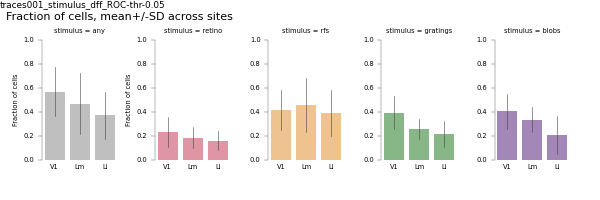

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/figures fraction_responsive_test-ROC-thr-0


In [28]:
%matplotlib notebook
e_colors = {'retino': 'crimson', 'rfs': 'darkorange', 
            'gratings': 'green', 'blobs': 'indigo',
            'any': 'gray'}

fg = sns.FacetGrid(col='stimulus', data=COUNTS, height=2.5, aspect=0.6,
                  col_order=['any', 'retino', 'rfs', 'gratings', 'blobs'],
                  hue='stimulus', palette=e_colors) #'colorblind')
fg.map(sns.barplot, 'visual_area', 'fraction_responsive', 
         order=visual_areas, ci='sd', alpha=0.5, errwidth=0.5)

sns.despine(bottom=True)

for ai, ax in enumerate(fg.axes.flat):
    ax.set_xlabel('')
    ax.tick_params(which='both', axis='x', size=0)
    ax.tick_params(labelleft=True)
    ax.set_ylim([0, 1])
    if ai==0 or ai==1:
        ax.set_ylabel('Fraction of cells')
    #ax.set_box_aspect(2)
pl.subplots_adjust(left=0.07, right=0.95, bottom=0.2, top=0.8, wspace=0.5)
fg.fig.text(0.01, 0.9, 'Fraction of cells, mean+/-SD across sites')

pplot.label_figure(fg.fig, data_id)
figname = 'fraction_responsive_test-%s-thr-%i' % (gratings_test, gratings_thr)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES')
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

# Select example cells spanning ALL stimuli

In [33]:
fit_thr=0.5; n_bootstrap_iters=1000; n_resamples=20;
assigned_cells, _ = select_assigned_cells(cells0, sdata, 
                                                      experiments=['gratings'])
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, 
                                responsive_test=gratings_test, 
                                n_stds=n_stds, responsive_thr=gratings_thr, 
                                n_bootstrap_iters=n_bootstrap_iters, 
                                n_resamples=n_resamples)
gdata, missing_ = gutils.aggregate_ori_fits(assigned_cells, 
                                traceid=traceid, fit_desc=ori_fit_desc, 
                                return_missing=True) 
print(missing_)

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/gratings_utils.py:174: RuntimeWarning: invalid value encountered in sqrt
  gfit = np.mean(bootr['results']['r2']) * (1-iqr) * np.sqrt(r2_comb)


['Lm_20191111_JC120_fov1']


In [308]:
gof_thr=0.25
gratings_ = gdata[gdata['gof']>=gof_thr][['visual_area', 'datakey', 'cell']]\
            .drop_duplicates()
gratings_.groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,224,224
Lm,547,547
V1,621,621


In [309]:
rf_cells, rf_meta = select_assigned_cells(cells0, sdata, 
                                          experiments=['rfs', 'rfs10']) 
# Drop repeat FOVs by selecting those with most RF fits
do_spherical_correction=False
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                               do_spherical_correction=do_spherical_correction)
rfdata = rfutils.aggregate_rfdata(rf_meta, rf_cells, 
                            fit_desc=rf_fit_desc, reliable_only=False)
# Combined rfs5/rfs10
RFS = rfutils.average_rfs_select(rfdata)

# Get RF cells
rfs_ = rfdata_avg[['visual_area', 'datakey', 'cell']]\
            .drop_duplicates()
rfs_.groupby(['visual_area']).count()

N dpaths: 65, N unfit: 0
N datasets included: 65, N sessions excluded: 4


,datakey,cell
visual_area,,
Li,450,450
Lm,422,422
V1,654,654


In [310]:
# Get blobs
trial_epoch='plushalf'
responsive_test='ROC'
responsive_thr=0.05
BLOBS = aggr.get_aggregate_data('blobs', traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr, n_stds=n_stds)
objects_ = BLOBS[['visual_area', 'datakey', 'cell']].drop_duplicates()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['blobs']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [0.0 -15.0], y: [0.0 -5.0]


In [311]:
# retinodata
retino_thr=0.01
retino_delay=1
retinodata = aggr.get_aggregate_retinodata(traceid=traceid, 
                        mag_thr=retino_thr, delay_thr=retino_delay)
retino_ = aggr.get_responsive_retino(retinodata, mag_thr=retino_thr)


In [312]:
f_=[]
for (va, dk), curr_rfs in rfs_.groupby(['visual_area', 'datakey']):
    cells_1 = curr_rfs['cell'].unique()
    # Get gratings cells
    curr_grat = gratings_[(gratings_.visual_area==va) & (gratings_.datakey==dk)].copy()
    cells_2 = curr_grat['cell'].unique()
    # Get cells in both
    common_ = np.intersect1d(cells_1, cells_2)
    # Get blobs
    curr_obj = objects_[(objects_.visual_area==va) & (objects_.datakey==dk)].copy()
    cells_3 = curr_obj['cell'].unique()
    common_1 = np.intersect1d(common_, cells_3)
    # Get retino
    curr_ret = retino_[(retino_.visual_area==va) & (retino_.datakey==dk)].copy()
    cells_4 = curr_ret['cell'].unique()
    common_2 = np.intersect1d(common_1, cells_4)
    
    final_cells = curr_rfs[curr_rfs['cell'].isin(common_2)]
    f_.append(final_cells)
ccounts = pd.concat(f_)
ccounts.shape

(180, 3)

In [313]:
ccounts.groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,15,15
Lm,44,44
V1,121,121


In [314]:
ccounts[ccounts['visual_area']=='Li']

,visual_area,datakey,cell
61,Li,20190602_JC091_fov1,33.0
66,Li,20190602_JC091_fov1,39.0
67,Li,20190602_JC091_fov1,41.0
68,Li,20190602_JC091_fov1,42.0
69,Li,20190602_JC091_fov1,43.0
72,Li,20190602_JC091_fov1,47.0
74,Li,20190602_JC091_fov1,50.0
81,Li,20190602_JC091_fov1,64.0
85,Li,20190602_JC091_fov1,70.0
88,Li,20190602_JC091_fov1,73.0


In [315]:
va='Li'
#dk='20190602_JC091_fov1'

currd=[]
for dk, g in ccounts[(ccounts['visual_area']=='Li')].groupby(['datakey']):
    curr_rois = g['cell'].unique()
    nd = NDATA[(NDATA.visual_area=='Li') & (NDATA.datakey==dk)
                & (NDATA['cell'].isin(curr_rois))].copy()
    currd.append(nd)
bdata = pd.concat(currd, axis=0)
bdata.shape

(22488, 6)

In [316]:
# np.reshape(bdata.groupby(['config'])['response'].mean().index.tolist(), (10, 5)).T

In [317]:
li_ccounts = ccounts[(ccounts['visual_area']=='Li')].copy()

<IPython.core.display.Javascript object>


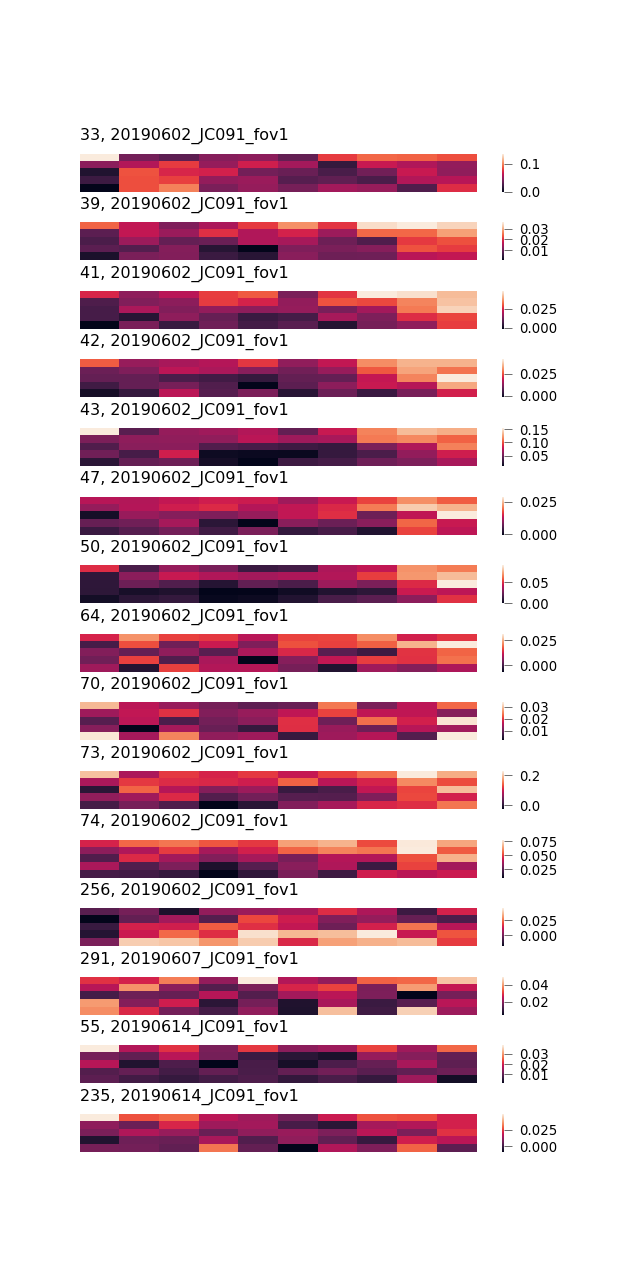

In [318]:
ncells_pass = li_ccounts.shape[0]
fig, axn = pl.subplots(ncells_pass, 1, figsize=(4,8))
for ai, ((dk, ri), df_) in enumerate(bdata.groupby(['datakey', 'cell'])):
    obj_map = np.reshape(df_.groupby(['config'])['response'].mean().values, (10, 5)).T
    ax=axn[ai]
    sns.heatmap(obj_map, ax=ax)
    ax.set_title('%i, %s' % (ri, dk), loc='left')
    ax.axis('off')
pl.subplots_adjust(wspace=0.5, hspace=0.8, bottom=0.1)

In [204]:
sdf = hutils.get_stimuli(dk, 'blobs')


In [337]:
assigned_cells[(assigned_cells.datakey=='20190607_JC091_fov1')]['cell'].unique()

array([512., 513., 514., 522.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,
        18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,
        44.,  50.,  51., 523., 524.,  92.,  93.,  94.,  95.,  96.,  97.,
        98.,  99., 100., 101., 102., 103., 104., 105., 106., 107., 108.,
       109., 110., 111., 112., 113., 114., 115., 116., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 153., 154., 155., 156., 157., 158., 159.,
       160., 161., 162., 163., 164., 165., 166., 167., 168., 169., 170.,
       171., 172., 173., 174., 175., 176., 177., 178., 179., 180., 181.,
       182., 183., 184., 185., 186., 187., 188., 189., 190., 191., 192.,
       193., 194., 195., 196., 197., 198., 199., 200., 201., 202., 203.,
       204., 205., 206., 207., 208., 209., 210., 211., 212., 213., 214.,
       215., 216., 217., 218., 219., 220., 221., 22

In [361]:
va='Li'
# dk = '20190614_JC091_fov1' #'20190602_JC091_fov1'
# rid = 304 #234 #43 #234
# dk = '20190602_JC091_fov1' #'20190602_JC091_fov1'
# rid = 51 #43 #43 #234
dk = '20190614_JC091_fov1' #'20190602_JC091_fov1'
rid = 343 #234 #43 #234

gd = gdata[(gdata.visual_area==va) & (gdata.datakey==dk) & (gdata['cell']==rid)].copy()
print('gratings, %.2f' % gd['gof'].max())

bd = BLOBS[(BLOBS.visual_area==va) & (BLOBS.datakey==dk) & (BLOBS['cell']==rid)].copy()
print('blobs, %.2f' % bd.dropna().groupby(['config']).mean()['response'].max())

rd = RFS[(RFS.visual_area==va) & (RFS.datakey==dk) & (RFS['cell']==rid)].copy()
print('RF: r2=%.2f' % rd['r2'].max())

retd = retino_[(retino_.visual_area==va) & (retino_.datakey==dk) & (retino_['cell']==rid)]
print(retd[['mag_az', 'mag_el']].max(axis=1))

gratings, nan
blobs, 0.09
RF: r2=0.94
Series([], dtype: float64)


In [362]:
RFS[(RFS.visual_area==va) & (RFS.datakey==dk) & (RFS['cell']==rid)]

,datakey,animalid,session,cell,x0,y0,fwhm_x,fwhm_y,theta,r2,...,ratio_xy,theta_c,theta_Mm_deg,major_axis,minor_axis,anisotropy,theta_Mm_c,aniso_index,visual_area,experiment
339,20190614_JC091_fov1,JC091,20190614,343.0,44.939706,-18.556217,26.652976,35.422658,1.320921,0.938588,...,0.752427,1.320921,165.683206,15.073471,11.341692,0.141274,-0.249875,-0.071405,Li,rfs10


In [363]:
rd.columns

Index(['datakey', 'animalid', 'session', 'cell', 'x0', 'y0', 'fwhm_x',
       'fwhm_y', 'theta', 'r2', 'fovnum', 'std_x', 'std_y', 'fwhm_avg',
       'std_avg', 'area', 'fx', 'fy', 'ratio_xy', 'theta_c', 'theta_Mm_deg',
       'major_axis', 'minor_axis', 'anisotropy', 'theta_Mm_c', 'aniso_index',
       'visual_area', 'experiment'],
      dtype='object')

In [132]:
dk = '20190617_JC097_fov1'
session, animalid, fovn = hutils.split_datakey_str(dk)
fov='FOV%i_zoom2p0x' % fovn
try:
    roiid = roiutils.get_roiid_from_traceid(animalid, session, fov, 
                                            traceid=traceid)
except Exception as e:
    print(e)
    print("[%s] Unable to get roiid (%s)" % (dk, traceid))
    roiid=None
# Select best retino run (if there are multiple)
all_retinos = pd.DataFrame(retutils.get_average_mag_across_pixels(dk))
retinorun = all_retinos.loc[all_retinos[1].idxmax()][0]
retinoid, RETID = retutils.load_retino_analysis_info(dk, use_pixels=False, roiid=roiid)
print(retinorun, retinoid)

retino_run1 analysis002


In [180]:
scaninfo = retutils.get_protocol_info(dk, run=retinorun)
scaninfo.keys()

dict_keys(['acquisition', 'acquisition_base_dir', 'animal_id', 'base_filename', 'frame_idxs', 'frame_nums', 'frame_rate', 'frame_tstamps_sec', 'lines_per_frame', 'nchannels', 'ntiffs', 'nvolumes', 'params_path', 'pixels_per_line', 'raw_simeta_path', 'rawtiff_dir', 'roi_dir', 'rootdir', 'run', 'session', 'slices', 'trace_dir', 'volume_rate', 'stimulus', 'trials'])

In [170]:
importlib.reload(retutils)

<module 'analyze2p.retinotopy.utils' from '/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/retinotopy/utils.py'>

In [169]:
RETID['PARAMS']['downsample_factor']


'2'

In [266]:
soma_traces = retutils.load_roi_traces(dk, run=retinorun,
                 analysisid=retinoid, trace_type='corrected', 
                    detrend_after_average=True, temporal_ds=7)


In [268]:
dff_soma = dict((cond, (tdf - tdf.mean(axis=0))/ tdf.mean(axis=0)) \
                for cond, tdf in soma_traces.items())


In [152]:
mag_thr=0.02
delay_thr=1.0
va='V1'

assigned_, ret_meta = aggr.select_assigned_cells(cells0, 
                                                    sdata, experiments=['retino'])
curr_cells = assigned_[(assigned_.visual_area==va) 
                     & (assigned_.datakey==dk)]
retdf = retutils.get_retino_fft(dk, curr_cells=curr_cells, 
                        mag_thr=mag_thr, delay_thr=delay_thr,
                        create_new=False,use_pixels=False)
# Sort cels by mag ratio
sorted_mags = retdf[['mag_az', 'mag_el']].mean(axis=1).sort_values(ascending=False)
sorted_mags.iloc[0:10]

In [194]:
# Convert x-axis to SEC
frames_tsec = dff_soma['right'].index.to_numpy()*(1./scaninfo['stimulus']['frame_rate'])

cycles_tsec = scaninfo['stimulus']['cycle_start_ixs']*(1./scaninfo['stimulus']['frame_rate'])

<IPython.core.display.Javascript object>


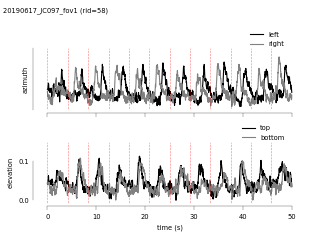

left
right
top
bottom


In [271]:
cond_colors = {'top': 'black', 'bottom': 'grey', 
               'left': 'black', 'right': 'grey'}
cond_dict = {'azimuth': ['left', 'right'],
             'elevation': ['top', 'bottom']}
lw=1

fig, axn = pl.subplots(2, 1, sharex=True, sharey=False, figsize=(4,3))
for ai, (axis_label, cond_pair) in enumerate(cond_dict.items()):
    ax=axn[ai]
    for cond, cond_color in zip(cond_pair, [cond_colors[k] for k in cond_pair]):
        print(cond)
        vs = dff_soma[cond][rid].values
        if min(vs) < 0:
            vs -= np.min(dff_soma[cond][rid].values)
        ax.plot(frames_tsec, vs, lw=lw, color=cond_color, label=cond)
        ax.set_ylabel(axis_label)
    ax.legend(bbox_to_anchor=(0.95,.92), loc='lower right', frameon=False)
    ax.set_ylim([-0.01, 0.15])
    if ai==1:
        ax.set_yticks(np.linspace(0, 0.1, 2))
        ax.set_yticklabels(np.linspace(0, 0.1, 2))
        ax.tick_params(which='both', axis='y', size=0)
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])
for ax in axn.flat:
    for cyc in cycles_tsec:
        ax.axvline(x=cyc, ls=':', c='red', lw=0.5)
axn[1].set_xlabel('time (s)')
sns.despine(trim=True, offset=2)

pl.subplots_adjust(bottom=0.15, hspace=0.5, top=0.8, right=0.95, left=0.11)
fig.text(0.01, 0.95, '%s (rid=%i)' % (dk, rid))

pl.savefig(os.path.join(FIGDIR, 'examples', 'movingbar__%s_%s.svg' % (va, dk)))


<IPython.core.display.Javascript object>


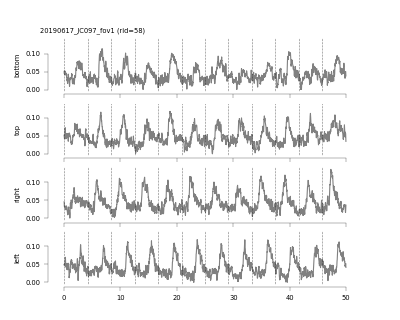

Text(0.1, 0.9, '20190617_JC097_fov1 (rid=58)')

In [203]:
rid = 58
retino_conds = dff_soma.keys()
fig, axn = pl.subplots(len(retino_conds), 1, sharex=True, sharey=True)
for ax, cond in zip(axn.flat, retino_conds):
    vs = dff_soma[cond][rid].values
    if min(vs) < 0:
        vs -= 0 #np.min(dff_soma[cond][rid].values)/4.
    ax.plot(frames_tsec, vs, lw=1, color='gray')
    ax.set_ylabel(cond)
for ax in axn.flat:
    for cyc in cycles_tsec:
        ax.axvline(x=cyc, ls=':', c='k', lw=0.5)
    sns.despine(trim=True, offset=2, ax=ax)

fig.text(0.1, 0.9, '%s (rid=%i)' % (dk, rid))

In [243]:
np.linspace(0, 0.1, 2)

array([0. , 0.1])

In [265]:
if not os.path.exists(os.path.join(FIGDIR, 'examples')):
    os.makedirs(os.path.join(FIGDIR, 'examples'))